In [2]:
pip install torch torchvision opencv-python numpy timm


In [3]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
!git clone https://github.com/isl-org/MiDaS.git
%cd MiDaS
!pip install -r requirements.txt


fatal: destination path 'MiDaS' already exists and is not an empty directory.
/content/MiDaS
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [5]:
!mkdir -p weights
!wget https://github.com/isl-org/MiDaS/releases/download/v3_1/dpt_large_384.pt -P weights/


--2025-02-14 05:32:46--  https://github.com/isl-org/MiDaS/releases/download/v3_1/dpt_large_384.pt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-02-14 05:32:46 ERROR 404: Not Found.



In [6]:
import torch
import cv2
import numpy as np
from torchvision.transforms import Compose, Normalize, ToTensor
from midas.midas_net import MidasNet
from midas.model_loader import load_model


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
import os
print(os.listdir("weights/"))  # Check if 'dpt_large_384.pt' exists


['midas_v21_small_256.pt', '.placeholder', 'dpt_large_384.pt']


In [9]:
import torch
model = torch.hub.load("isl-org/MiDaS", "DPT_Large")
model.eval()
print("MiDaS model loaded successfully!")


Using cache found in /root/.cache/torch/hub/isl-org_MiDaS_master


MiDaS model loaded successfully!


In [10]:
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get uploaded filename
print(f"Using uploaded image: {image_path}")


Saving image1.png to image1 (2).png
Using uploaded image: image1 (2).png


In [11]:
import cv2
import numpy as np
from torchvision.transforms import Compose, Normalize, ToTensor


In [12]:
# Preprocessing function
def preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert OpenCV BGR to RGB
    transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tensor = transform(image / 255.0).unsqueeze(0)  # Convert to tensor & add batch dimension
    return tensor.to(torch.float32)

In [13]:
# Process the uploaded image
input_tensor = preprocess(image_path)

# Print tensor type to verify
print(f"Input tensor type: {input_tensor.dtype}")  # Should print "torch.float32"

Input tensor type: torch.float32


In [14]:
print(input_tensor)

tensor([[[[-1.8268, -1.8268, -1.8268,  ..., -1.8097, -1.8097, -1.8097],
          [-1.8268, -1.8268, -1.8268,  ..., -1.8097, -1.8097, -1.8097],
          [-1.8268, -1.8268, -1.8268,  ..., -1.8097, -1.8097, -1.8097],
          ...,
          [-1.8268, -1.8268,  1.4783,  ..., -1.8268, -1.8268, -1.8268],
          [-1.8268, -1.8268,  1.4269,  ..., -1.8268, -1.8268, -1.8268],
          [-1.8268, -1.8268,  1.4440,  ..., -1.8268, -1.8268, -1.8268]],

         [[-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630],
          [-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630],
          [-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630],
          ...,
          [-1.5630, -1.5630,  1.4482,  ..., -1.5805, -1.5805, -1.5805],
          [-1.5630, -1.5630,  1.3957,  ..., -1.5805, -1.5805, -1.5805],
          [-1.5630, -1.5630,  1.4132,  ..., -1.5805, -1.5805, -1.5805]],

         [[-1.2293, -1.2293, -1.2293,  ..., -1.2293, -1.2293, -1.2293],
          [-1.2293, -1.2293, -

In [15]:
with torch.no_grad():
    depth = model(input_tensor)

In [16]:
depth_map = depth.squeeze().cpu().numpy()  # Convert to NumPy array

In [17]:
import matplotlib.pyplot as plt

In [18]:

# Normalize depth map for better visualization
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min()) * 255
depth_map = depth_map.astype(np.uint8)



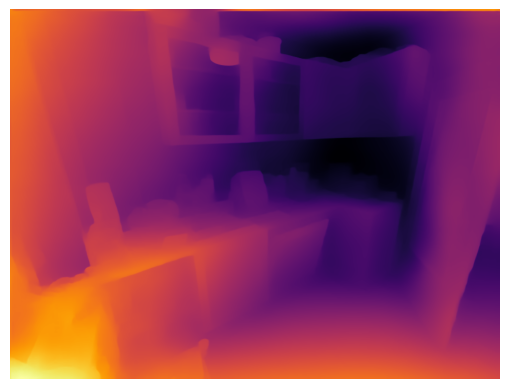

In [19]:

# Display the depth map
plt.imshow(depth_map, cmap="inferno")
plt.axis("off")
plt.show()

In [20]:
import cv2

# Save the depth map as an image
cv2.imwrite("depth_map.png", depth_map)
print("Depth map saved as depth_map.png")


Depth map saved as depth_map.png


In [21]:
from google.colab import files
files.download("depth_map.png")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **(A) Blur Background Based on Depth**

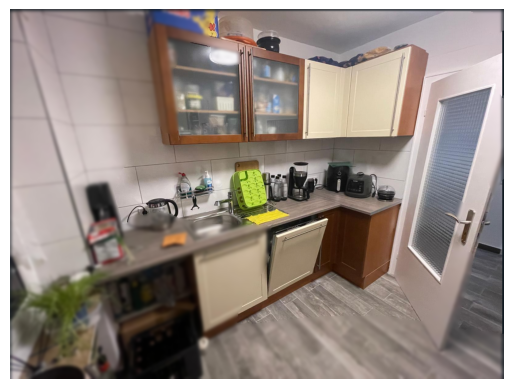

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Thresholding depth map to create a mask
depth_blur_threshold = np.percentile(depth_map, 50)  # Set threshold at 50% depth

# Load the original image
image = cv2.imread(image_path)

# Resize depth map to match image size
depth_map_resized = cv2.resize(depth_map, (image.shape[1], image.shape[0]))

# Create blur mask based on depth
blur_mask = depth_map_resized > depth_blur_threshold

# Apply Gaussian Blur to the entire image
blurred_image = cv2.GaussianBlur(image, (15, 15), 0)

# Combine blurred background and sharp foreground
final_image = image.copy()
final_image[blur_mask] = blurred_image[blur_mask]

# Show the final image
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


## **(B) 3D Point Cloud from Depth**

In [23]:
#!pip install open3d


In [25]:
!apt-get install -y xvfb libgl1-mesa-glx


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libgl1-mesa-glx libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 10 newly installed, 0 to remove and 20 not upgraded.
Need to get 7,820 kB of archives.
After this operation, 12.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libgl1-mesa-glx amd64 23.0.4-0ubuntu1~22.04.1 [5,584 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1

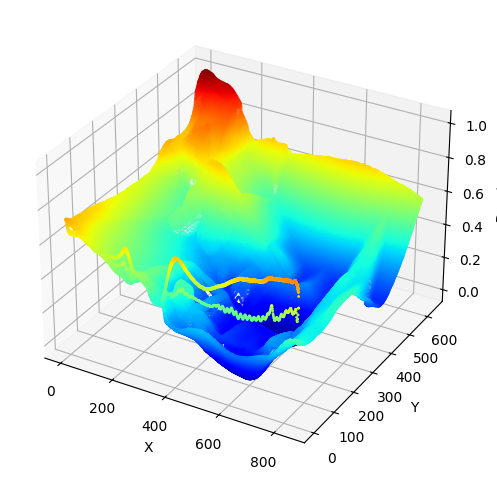

In [26]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Create a point cloud object
pcd = o3d.geometry.PointCloud()

# Get image dimensions
height, width = depth_map.shape

# Generate 3D coordinates
X, Y = np.meshgrid(np.arange(width), np.arange(height))
Z = depth_map / 255.0  # Normalize depth values
points = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)

pcd.points = o3d.utility.Vector3dVector(points)

# Convert Point Cloud to a Numpy Array for Visualization
xyz = np.asarray(pcd.points)

# Plot with Matplotlib (Headless)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=1, c=xyz[:, 2], cmap="jet")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Depth")
plt.show()


In [28]:
print(f"Number of points in the point cloud: {len(np.asarray(pcd.points))}")


Number of points in the point cloud: 542720


## **Using YOLO to detect objects in depth maps**

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-2-14 Python-3.11.11 torch-2.5.1+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 130MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


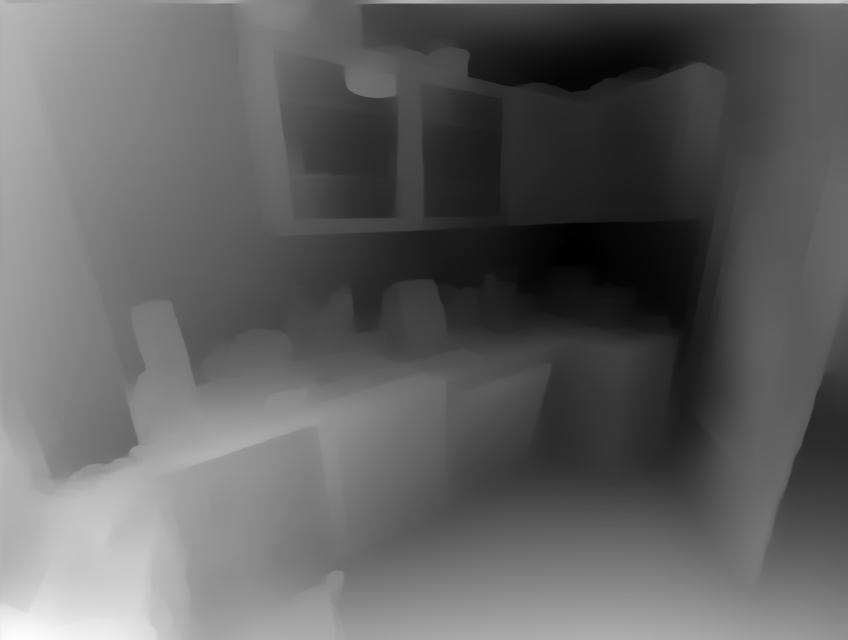

In [30]:
# Load a YOLO model and detect objects in depth data
import torch
model = torch.hub.load("ultralytics/yolov5", "yolov5s")

# Run detection on depth map
results = model(depth_map)
results.show()


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-2-14 Python-3.11.11 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


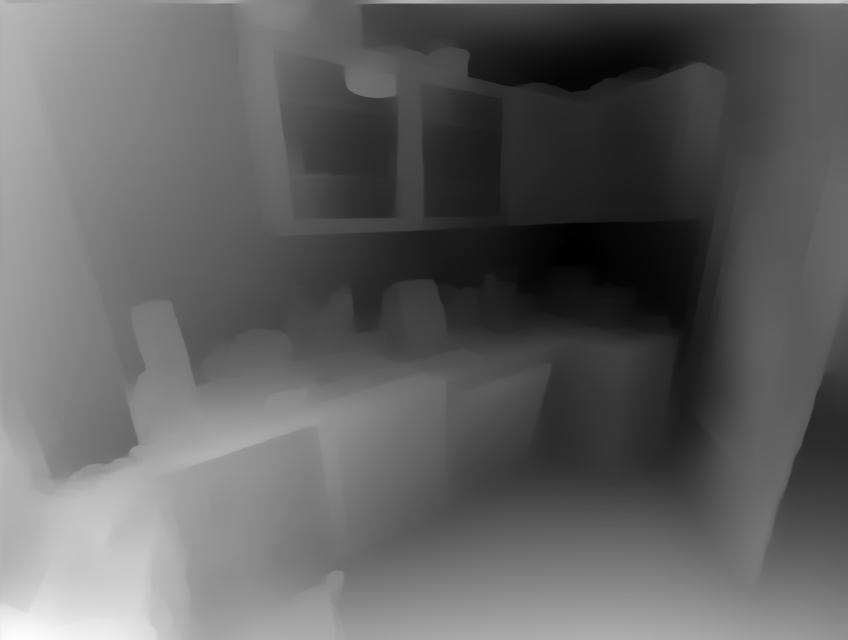

In [31]:
import torch
import cv2

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Load depth map
depth_image = cv2.imread("depth_map.png")

# Run YOLO object detection
results = model(depth_image)

# Show detections
results.show()


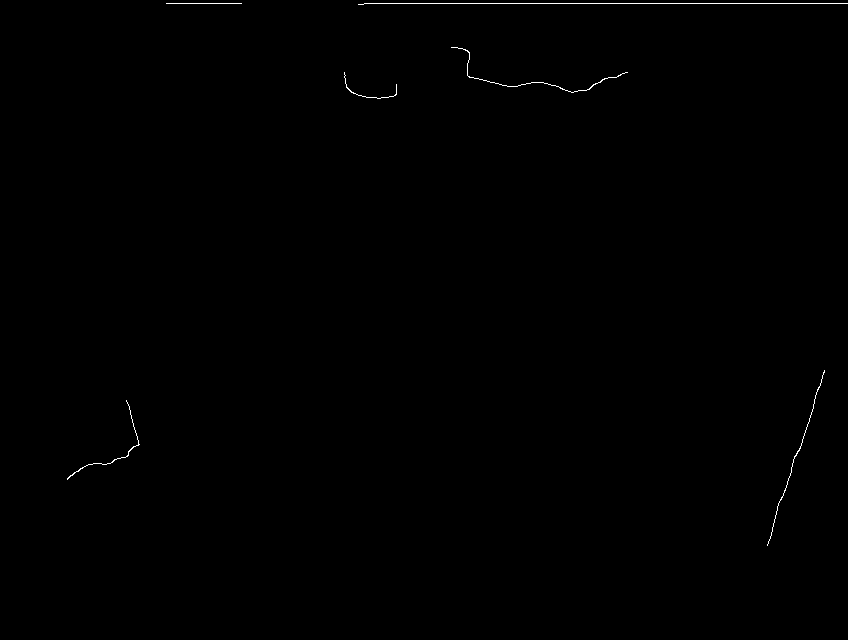

In [35]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import the correct function for Colab

# Load depth map
depth_image = cv2.imread("depth_map.png", 0)

# Apply edge detection
edges = cv2.Canny(depth_image, 50, 150)

# Save and display the edge-detected image
cv2.imwrite("edges.png", edges)

#  Use cv2_imshow() instead of cv2.imshow()
cv2_imshow(edges)


## **Next Steps: Estimating Kitchen Furniture Size from Depth Map**

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Reload depth map
depth_image = cv2.imread("depth_map.png", 0)

# Enhance contrast
depth_image = cv2.equalizeHist(depth_image)  # Improve contrast

# Apply edge detection with adjusted thresholds
edges = cv2.Canny(depth_image, 30, 100)  # Try lower thresholds

# Save and visualize the new edge map
cv2.imwrite("edges_fixed.png", edges)
plt.imshow(edges, cmap="gray")
plt.axis("off")
plt.show()



In [37]:
# Select a reference object (manually identified)
known_object_width_cm = 60  # Example: kitchen cabinet ~60 cm wide

# Select the bounding box of the reference object
x, y, w, h = cv2.boundingRect(contours[0])  # Select first detected object

# Compute the scale factor (cm per pixel)
scale_factor = known_object_width_cm / w
print(f"Scale Factor: {scale_factor:.2f} cm per pixel")

# Measure another object using the scale factor
x2, y2, w2, h2 = cv2.boundingRect(contours[1])  # Select another object
object_width_cm = w2 * scale_factor
print(f"Estimated Object Width: {object_width_cm:.2f} cm")




Scale Factor: 0.82 cm per pixel
Estimated Object Width: 47.67 cm


In [39]:
for i, contour in enumerate(contours[:5]):  # Limit to 5 objects
    x, y, w, h = cv2.boundingRect(contour)
    object_width_cm = w * scale_factor
    print(f"Object {i+1}: Estimated Width = {object_width_cm:.2f} cm")


Object 1: Estimated Width = 60.00 cm
Object 2: Estimated Width = 47.67 cm
Object 3: Estimated Width = 43.56 cm
Object 4: Estimated Width = 145.48 cm
Object 5: Estimated Width = 402.74 cm
